In [1]:
import sys
sys.path.append('../code/')
from gwBackground import *
from makeDelayedRateData import *
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../plotting.mplstyle')
from scipy.special import gammainc

blue = "#1f78b4"
blue_rgb = (31/255.,120/255.,180/255.)
lightblue = "#a6cee3"
green = "#33a02c"
red = "#e31a1c"

As a preliminary, precompute some data that gives us star formation rates and evolutionary time delays at a variety of redshifts.
Specifically, the cell below defines the following arrays:

   * `zs_merger` : An array (length M) of possible redshifts at which binaries might merge
   * `time_delays` : An array (length N) of possible source-frame time delays between binary formation and merger. Time delays are in units of Gyr
   * `zs_formation` : A 2D array (length MxN) that gives the *formation* redshift implied by each pair of merger redshifts and evolutionary time delays from `zs_merger` and `time_delays`
   * `formationRates` : An estimate of the global star formation rate (arbitrary overall normalization) at each redshift in `zs_formation`

In [2]:
rateData = generateTimeDelayData()
zs_merger = rateData['zs']
time_delays = rateData['tds']
zs_formation = rateData['formationRedshifts']
formationRates = rateData['formationRates']

Also import data defining the "power-law integrated sensitivity curves" (PI curves) for the O3 and (projected) O4 observing runs:

In [3]:
O3_PI_freqs,O3_PI = np.loadtxt('../input/O3PICurve.dat',unpack=True,usecols=(0,2),skiprows=4)
design_PI_freqs,design_PI = np.loadtxt('../input/Design_HLV_flow_10.txt',unpack=True,usecols=(0,1))

Next, instantiate an `OmegaGW_BBH` object to help us calculate the expected stochastic background for a variety of birefringence cases. Specifically, the arguments below tell us to consider a BBH population with component masses between 2-100 solar masses and situated across the range of redshifts spanned by `zs_merger`. Later on we will tell the object what specific mass and redshift distributions to assume when integrating across this mass and redshift range; the `gridSize` argument pertains to how precisely this integral is done across BBH masses.

**Note**: This might take a few minutes to run...

In [4]:
# Instantiate SGWB calculator
m_absolute_min = 2.
m_absolute_max = 100.
omg = OmegaGW_BBH(m_absolute_min,m_absolute_max,zs_merger,gridSize=(30,29))

Now that we have our stochastic background calculator ready, choose an assumed BBH mass distribution. This is done by choosing values for the following parameters:
   * `m_min`: Minimum BBH mass
   * `m_max`: Maximum BBH mass
   * `alpha`: Power-law index governing the bulk distribution of BBH component masses
   * `mu_peak`: Mean location of an additional Gaussian peak, on top of the bulk power law
   * `sig_peak`: Standard deviation of the Gaussian peak
   * `frac_peak`: Mixture fraction of events belonging to the Gaussian peak
   * `bq`: Power-law index governing the mass ratio distribution of BBHs

In [5]:
# Define hyperparameters describing mass distribution
R0 = 16.
m_min = 9.
m_max = 70.
dm_min = 0.5
dm_max = 10.
alpha = -3.8
mu_peak = 34.
sig_peak = 3.
frac_peak = 10.**(-2.7)
bq = 2

# Pass these to our SGWB calculator
omg.setProbs_plPeak(m_min,m_max,dm_min,dm_max,alpha,mu_peak,sig_peak,frac_peak,bq)

/Users/tcallister/Documents/Repositories/stochastic-birefringence/figures/../code/gwBackground.py:344: RuntimeWarning: divide by zero encountered in divide
  probs_m2 = (1.+bq)*np.power(self.m2s_2d,bq)/(np.power(self.m1s_2d,1.+bq)-2.**(1.+bq))


Finally, define a model for the BBH merger rate as a function of redshift.
Assume a merger rate following a model for the rate of *low metallicity* star formation, subject to a distribution of evolutionary time delays between binary formation and merger

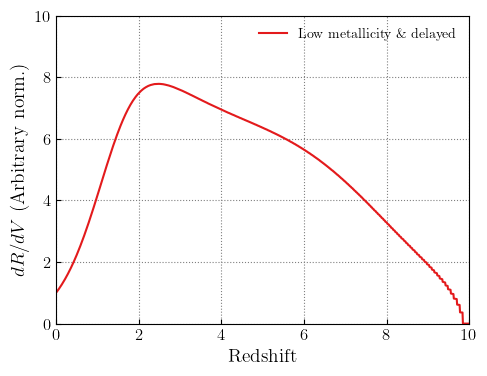

In [6]:
# The following function is an approximation to the integrated fraction of star formation below
# Z=Z_sun/10 as a function of redshift
low_Z_fraction = gammainc(0.84,(0.1**2.)*np.power(10.,0.3*zs_formation))

# Multiply by total formation rate to get the rate of low metallicity star formation
weightedFormationRates = formationRates*low_Z_fraction

# Convolve formation rate with time-delay distribution
# Set t_min = 10 Myr
tdMin = 0.01
dpdt = np.power(time_delays,-1)
dpdt[time_delays<tdMin] = 0.
dRdV = weightedFormationRates.dot(dpdt)
dRdV /= dRdV[0]

# Plot
fig,ax = plt.subplots(figsize=(5.33,4))
ax.plot(zs_merger,dRdV,color=red,label='Low metallicity \& delayed')
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.legend(loc='upper right',frameon=False,fontsize=10)
ax.set_xlabel('Redshift')
ax.set_ylabel('$dR/dV$ (Arbitrary norm.)')
plt.show()

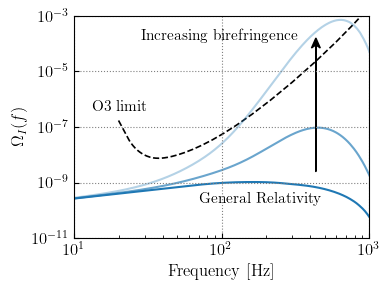

In [7]:
fig,ax = plt.subplots(figsize=(4,3))

# Define a range of frequencies at which we want to evaluate the SGWB
freqs = np.logspace(1,3.5,300)

# Loop across kappa values
kappa_dcs = np.array([0,0.06,0.12])
for i,k in enumerate(kappa_dcs):
    
    # At each value, compute and plot the resulting SGWB
    # Note that the "redshift" kappa is fixed to zero
    Omega_I_f,Omega_V_f = omg.eval(R0,dRdV,freqs,k,0)
    ax.plot(freqs,Omega_I_f,color=blue,alpha=1.-float(i/kappa_dcs.size),zorder=1)
    
# Overplot O3 and O4 PI sensitivity curves
ax.plot(O3_PI_freqs,O3_PI,color='black',lw=1.2,ls='--',zorder=-2)
    
# Misc formatting
ax.text(0.84, 0.16, 'General Relativity', horizontalalignment='right',transform=ax.transAxes,fontsize=11)
plt.arrow(0.82, 0.3, 0, 0.6, transform=ax.transAxes,
          length_includes_head=True, head_width=0.03, overhang=0.3, color='black')
ax.text(0.76, 0.89, 'Increasing birefringence', horizontalalignment='right',transform=ax.transAxes,fontsize=11)
ax.text(0.25, 0.57, 'O3 limit', horizontalalignment='right',transform=ax.transAxes,fontsize=11)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10,1000)
ax.set_ylim(1e-11,1e-3)
ax.set_xlabel('Frequency [Hz]',fontsize=12)
ax.set_ylabel('$\Omega_I(f)$',fontsize=12)

plt.tight_layout()
plt.savefig('birefringence_simple_example_spectra.pdf',bbox_inches='tight',dpi=200)
plt.show()